In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import constants
from scipy.integrate import quad

data = pd.read_csv("input/type_Ia_lt_001.csv")

print(data.head(10))

        Name  Disc. Date     Host Name                         z  dL (Mpc)  \
0    SN1972E  1972/05/06      NGC 5253                  0.001358    2.7000   
1    SN1895B  1895/07/07      NGC 5253                    0.0014    2.7000   
2    SN1986G  1986/05/03      NGC 5128  0.00183,0.000848,0.00103    2.8000   
3    SN1937C  1937/08/16       IC 4182         0.001071,0.001071    3.0000   
4    SN1983N  1983/07/03      NGC 5236   0.00308,0.00321,0.00171    4.3000   
5  SN2021abt  2021/01/10  LEDA 1022096                  0.001429    6.3312   
6   SN2012cg  2012/05/17      NGC 4424                  0.001458    6.4598   
7    SN1937D  1937/09/09      NGC 1003                   0.00518    8.0000   
8    SN1971I  1971/05/24      NGC 5055           0.00131,0.00344    8.0000   
9   SN2010el  2010/06/19      NGC 1566               0.005,0.005    8.0000   

      Type  
0       Ia  
1       Ia  
2  Ia-91bg  
3       Ia  
4       Ib  
5       Ia  
6       Ia  
7       Ia  
8       Ia  
9  Ia-02cx 

In [2]:
data.dropna(subset=['z','dL (Mpc)'], inplace=True)
data_a = data["z"].str.split(",", expand=True)
data["z"] = data_a[0].astype(float)
print(data.head(10))

        Name  Disc. Date     Host Name         z  dL (Mpc)     Type
0    SN1972E  1972/05/06      NGC 5253  0.001358    2.7000       Ia
1    SN1895B  1895/07/07      NGC 5253  0.001400    2.7000       Ia
2    SN1986G  1986/05/03      NGC 5128  0.001830    2.8000  Ia-91bg
3    SN1937C  1937/08/16       IC 4182  0.001071    3.0000       Ia
4    SN1983N  1983/07/03      NGC 5236  0.003080    4.3000       Ib
5  SN2021abt  2021/01/10  LEDA 1022096  0.001429    6.3312       Ia
6   SN2012cg  2012/05/17      NGC 4424  0.001458    6.4598       Ia
7    SN1937D  1937/09/09      NGC 1003  0.005180    8.0000       Ia
8    SN1971I  1971/05/24      NGC 5055  0.001310    8.0000       Ia
9   SN2010el  2010/06/19      NGC 1566  0.005000    8.0000  Ia-02cx


In [3]:
# z<0.1かつType-Iaのものを抽出(extracting)．
data_ext = data[(data["z"]<0.1) & (data["Type"]=="Ia")]
print(data_ext.head(10))


         Name  Disc. Date     Host Name         z  dL (Mpc) Type
0     SN1972E  1972/05/06      NGC 5253  0.001358    2.7000   Ia
1     SN1895B  1895/07/07      NGC 5253  0.001400    2.7000   Ia
3     SN1937C  1937/08/16       IC 4182  0.001071    3.0000   Ia
5   SN2021abt  2021/01/10  LEDA 1022096  0.001429    6.3312   Ia
6    SN2012cg  2012/05/17      NGC 4424  0.001458    6.4598   Ia
7     SN1937D  1937/09/09      NGC 1003  0.005180    8.0000   Ia
8     SN1971I  1971/05/24      NGC 5055  0.001310    8.0000   Ia
10  SN2021qvv  2021/06/23      NGC 4442  0.001825    8.0881   Ia
11  SN2021hcz  2021/03/24      NGC 1400  0.001861    8.2479   Ia
12    SN1989B  1989/01/30      NGC 3627  0.002425    9.0000   Ia


*Result_linear************
y = ax + b
a =  4782.177150090044 +- 2.186832224300236
b =  -7.687425469405795 +- 0.1233155732844946
*******************
*Result_nonlinear************
y = ax^2 + bx + c
a =  2472.6704356495447 +- 89.10796958426265
b =  4529.837219373714 +- 9.332074708680791
c =  -2.7191396025783803 +- 0.2145417870606813
*******************
*global_var************
ハッブル定数：H_0 = 1/a_linear/1000 = 62.69[s/Km/Mpc]
ハッブル時間：t_0=155.9[億年]
a_linear = 4782.177150090044
b_linear = -7.687425469405795
*******************


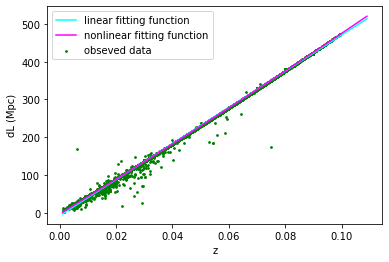

In [4]:
#fittingを行うメインの関数
def fitting_linear(data):
    z_observed = data["z"]
    dl_observed = data["dL (Mpc)"]
    #モデル式を表す関数
    def linear_func(X, a, b): # １次式 Y=aX+b
        Y = a*X + b
        return Y
    
    def nonlinear_func(X, a, b, c): # 2次式 Y =aX^2+bX+c
        Y = a*(X**2) + b*X + c
        return Y 
    
    # plot部分
    def observed_plot():
        x = np.arange(0.001,0.11,0.001)# 0.01~0.1まで0.01刻みのリストを作成
        y_linear = x*popt[0]+popt[1]# y=ax+b
        y_nonlinear = npopt[0]*(x**2)+npopt[1]*x+npopt[2]# y=ax^2+bx+c
        plt.plot(x, y_linear, color = "cyan", label="linear fitting function")
        plt.plot(x,y_nonlinear,color = "magenta", label= "nonlinear fitting function")
        plt.scatter(z_observed, dl_observed, s=3,color="green",label="obseved data")
        plt.xlabel("z")
        plt.ylabel("dL (Mpc)")
        plt.rcParams["figure.figsize"] = [27,18]# グラフのサイズを調整
        plt.legend()# 凡例を表示
        plt.show()
        
    #fittingのメイン計算部分
    #linear
    popt, pcov = curve_fit(linear_func,z_observed,dl_observed) #poptは最適推定値、pcovは共分散が出力される
    perr = np.sqrt(np.diag(pcov)) #推定されたパラメータの各々の誤差

    #nonlinear
    npopt, npcov = curve_fit(nonlinear_func,z_observed,dl_observed) #poptは最適推定値、pcovは共分散が出力される
    nperr = np.sqrt(np.diag(npcov)) #推定されたパラメータの各々の誤差

    #fitting_linearの外でも使いたい変数を，global変数として宣言する．
    global H_0
    global t_0
    global a_linear
    global b_linear
    a_linear = popt[0]
    b_linear = popt[1]
    H_0 = 1/popt[0]*constants.c/1000
    t_0 = 1/(H_0) *constants.c/1000 *3.26 *1000000
    #fittingの結果をターミナルに表示
    # print("*input*************")
    # print(data.head(10))
    # print("*******************")
    print("*Result_linear************")
    print("y = ax + b")
    print("a = ", popt[0], "+-", perr[0])
    print("b = ", popt[1], "+-", perr[1])
    print("*******************")
    print("*Result_nonlinear************")
    print("y = ax^2 + bx + c")
    print("a = ", npopt[0], "+-", nperr[0])
    print("b = ", npopt[1], "+-", nperr[1])
    print("c = ", npopt[2], "+-", nperr[2])
    print("*******************")
    print("*global_var************")
    print("ハッブル定数：H_0 = 1/a_linear/1000 = {:.2f}[s/Km/Mpc]".format(H_0))
    print("ハッブル時間：t_0={:.1f}[億年]".format(t_0*10**(-8)))
    print("a_linear = " + str(a_linear))
    print("b_linear = " + str(b_linear))
    print("*******************")
    observed_plot()
    return

fitting_linear(data_ext)

## case1は平坦な宇宙($\Omega_K=0$)，$\Omega_R=0$で$\Omega_\Lambda$を調整する  
- case1_1：$(\Omega_\Lambda,\Omega_K, \Omega_M, \Omega_R)=(1,0,0,0)$  
- case1_2：$(\Omega_\Lambda,\Omega_K, \Omega_M, \Omega_R)=(0.5,0,0.5,0)$  
- case1_3：$(\Omega_\Lambda,\Omega_K, \Omega_M, \Omega_R)=(0,0,1,0)$  

## case2は$\Omega_\Lambda=\Omega_R=0$で$\Omega_K,\Omega_M$を調整する  
- case2_1：$(\Omega_\Lambda,\Omega_K, \Omega_M, \Omega_R)=(0,1,0,0)$  
- case2_2：$(\Omega_\Lambda,\Omega_K, \Omega_M, \Omega_R)=(0,0,1,0)$  
- case2_3：$(\Omega_\Lambda,\Omega_K, \Omega_M, \Omega_R)=(0,-1,2,0)$

## dL積分を考えてみる．

$$d_L(z)=
\frac{1+z}{H_0\Omega_K^{1/2}}\times\sinh\left[
  \Omega_K^{1/2}\int_{1/(1+z)}^{1}
    \frac{dx}{x^2\sqrt{\Omega_{\Lambda}+\Omega_K x^{-2}+\Omega_M x^{-3}+\Omega_R x^{-4}}}
\right]$$

## 平坦な宇宙($\Omega_K=0$)，$\Omega_R=0$で$\Omega_\Lambda$を調整する

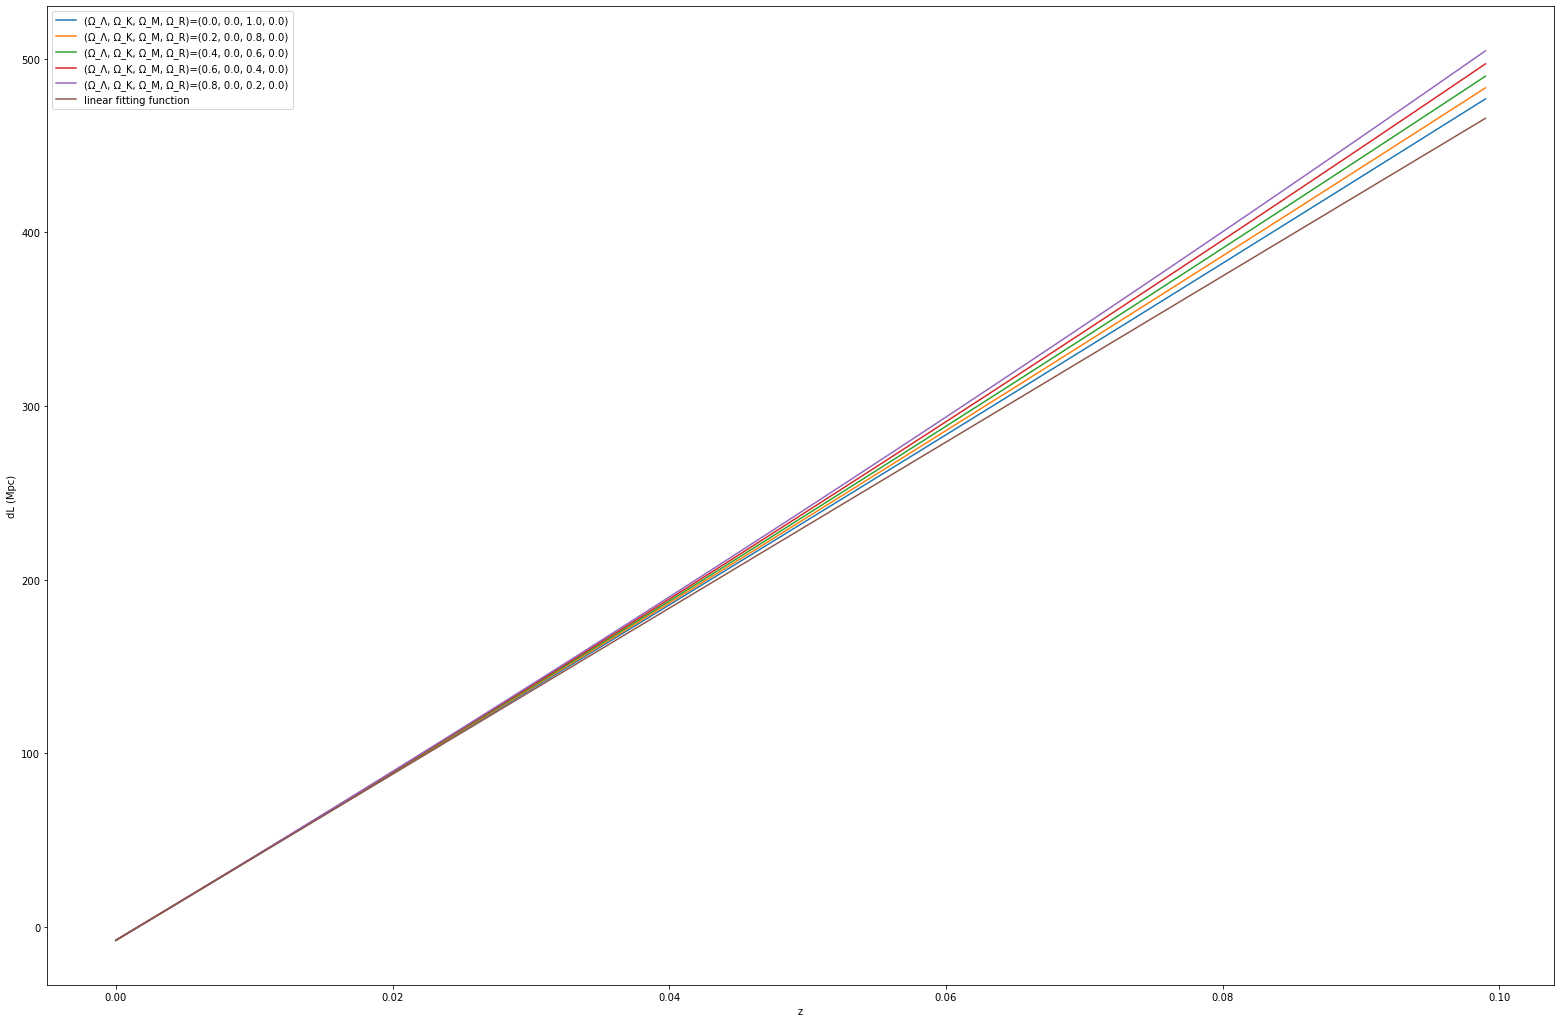

In [5]:
# 非積分関数
def func(x, a, b, c, d):
    return 1/(x**2*np.sqrt(a+b*x**(-2)+c*x**(-3)+d*x**(-4)))

# \Omega_K=0の特別な場合の初期値
a, b, c, d = -0.2, 0, 1.2, 0



for n in range(0,5):
    a += 0.2
    c -= 0.2
    z =[]
    dl = []
    for i in range(0,100):
        x = i*0.001
        v, err = quad(func,1/(1+x),1,args=(a,b,c,d))
        z.append(x)
        dl.append((1+x)*a_linear*v+b_linear)
    plt.plot(z,dl,label="(Ω_Λ, Ω_K, Ω_M, Ω_R)=({:.1f}, {:.1f}, {:.1f}, {:.1f})".format(a,b,c,d))
    del z,dl

x_linear = []
y_linear =[]
for i in range(0,100):
    x = i*0.001
    x_linear.append(x)
    y_linear.append(a_linear*x+b_linear)
plt.plot(x_linear,y_linear,label="linear fitting function")

plt.ylabel("dL (Mpc)")
plt.xlabel("z")
plt.legend()
plt.show()

## $\Omega_\Lambda=\Omega_R=0$で$\Omega_K,\Omega_M$を調整する  

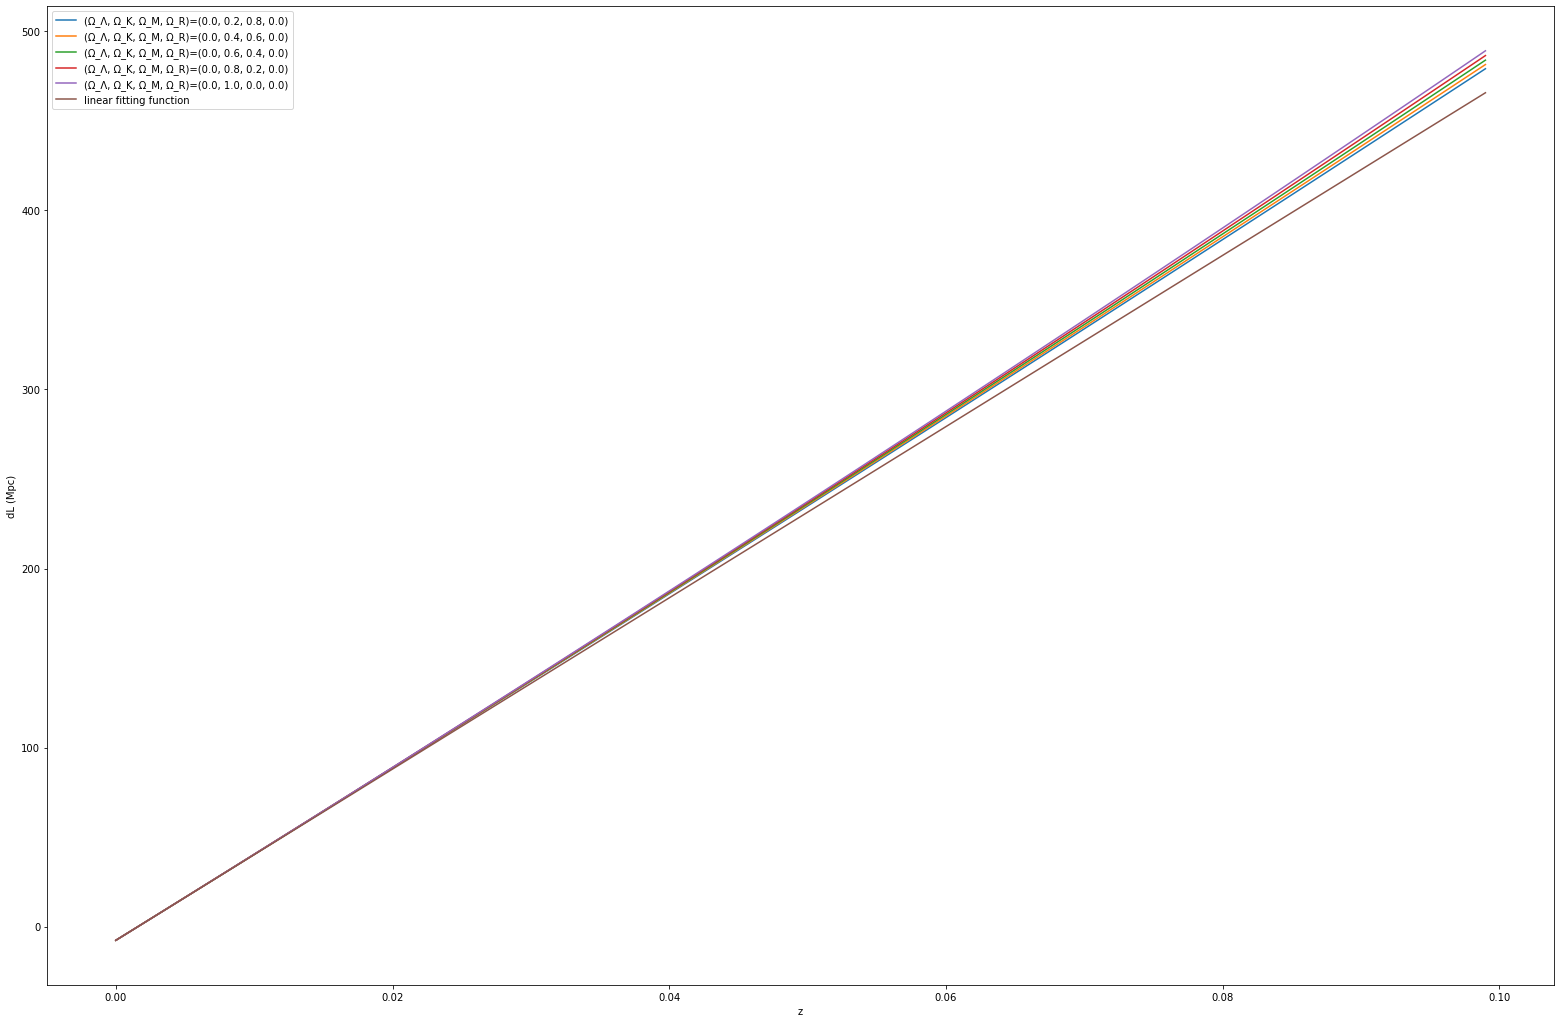

In [7]:
del a, b, c, d

# 非積分関数
def func(x, a, b, c, d):
    return 1/(x**2*np.sqrt(a+b*x**(-2)+c*x**(-3)+d*x**(-4)))

# \Omega_K=0の特別な場合の初期値
a, b, c, d = 0, 0, 1, 0



for n in range(0,5):
    b += 0.2
    c -= 0.2
    z =[]
    dl = []
    for i in range(0,100):
        x = i*0.001
        v, err = quad(func,1/(1+x),1,args=(a,b,c,d))
        z.append(x)
        dl.append((1+x)/b*a_linear*np.sinh(b*v)+b_linear)
    plt.plot(z,dl,label="(Ω_Λ, Ω_K, Ω_M, Ω_R)=({:.1f}, {:.1f}, {:.1f}, {:.1f})".format(a,b,c,d))
    del z,dl

x_linear = []
y_linear =[]
for i in range(0,100):
    x = i*0.001
    x_linear.append(x)
    y_linear.append(a_linear*x+b_linear)
plt.plot(x_linear,y_linear,label="linear fitting function")

plt.ylabel("dL (Mpc)")
plt.xlabel("z")
plt.legend()
plt.show()